# Importing Libs

In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import tqdm

from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import utils as uf
from torch.utils.tensorboard import SummaryWriter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading CIFAR Data

In [82]:
# Defining a transformer which would convert image to Tensor
transform = transforms.ToTensor()

# Loading both Training and Test Data
train_data = datasets.CIFAR10(root='./Data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='./Data', train=False, download=True, transform=transform)

# defining class names
global class_names
class_names = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']

Files already downloaded and verified
Files already downloaded and verified


In [83]:
# Checking Train Data
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [84]:
# Checking Test Data
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./Data
    Split: Test
    StandardTransform
Transform: ToTensor()

		Label : bird 



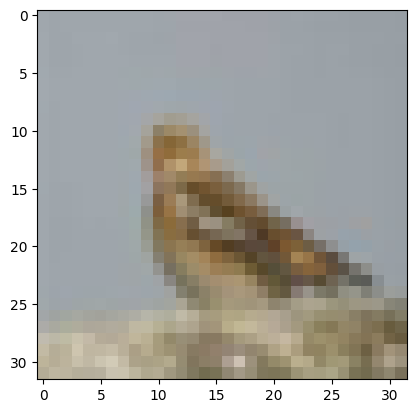

In [85]:
# Show Randomg Images from Training Set
random_num = random.randint(0,len(train_data))
uf.show_image(train_data[random_num],class_names)

# Data Loaders for train and test

In [86]:
# We will train our model in batches
# Let's create train and test loader to feed images in batches
# Also we need to shuffle data, so that model learn in a generalized way
torch.manual_seed(101)
train_loader = DataLoader(train_data,batch_size = 10,shuffle=True)
test_loader = DataLoader(test_data,batch_size = 10,shuffle=False)

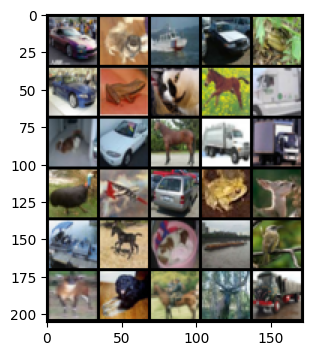

In [87]:
for images,labels in train_loader:
  break
im = make_grid(images,nrow=5)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(),(1,2,0)));

# Our CNN Model

In [88]:
class CNN_Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,15,5,1)
    self.conv2 = nn.Conv2d(15,40,3,1)
    self.fc1 = nn.Linear(6*6*40,500)
    self.fc2 = nn.Linear(500,120)
    self.fc3 = nn.Linear(120,84)
    self.fc4 = nn.Linear(84,10)
  def forward(self,X):
    #3,32,32
    X = F.relu(self.conv1(X)) #10,27,27
    X = F.max_pool2d(X,2,2) #10,13,13
    X = F.relu(self.conv2(X)) #32,25,25
    X = F.max_pool2d(X,2,2) #32,12,12
    X = X.view(-1,6*6*40) #flattening
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = F.relu(self.fc3(X))
    X = self.fc4(X)
    return F.log_softmax(X,dim=1)

# Training Model

In [89]:
torch.manual_seed(42)

model = CNN_Model().to(device)
model

CNN_Model(
  (conv1): Conv2d(3, 15, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(15, 40, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1440, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=10, bias=True)
)

In [90]:
# Total Number of Parameters
_=[]
for param in model.parameters():
  _.append(param.numel())
print(np.sum(_))

798214


In [91]:
# Defining Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [92]:
exp_num = uf.count_folders_inside('runs') + 1
writer = SummaryWriter(f'runs/exp{exp_num}')

In [93]:
import time
from tqdm import tqdm
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct=[]
test_correct=[]

for i in range(epochs):
  trn_corr = 0
  tst_corr = 0
  for b,(X_train,y_train) in enumerate(train_loader):
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    b+=1
    y_pred = model(X_train)
    loss = criterion(y_pred,y_train)
    predicted = torch.max(y_pred.data,1)[1]
    trn_corr += (predicted == y_train).sum()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if b%200 == 0:
      accuracy = trn_corr.item()*100/(100*b)
      print(f'Epoch : {i+1} Batch : {b} Loss : {loss.item()} Accuracy : {accuracy*10}')

  writer.add_scalar('training_loss', loss.item(), i)
  train_losses.append(loss.item())
  train_correct.append(trn_corr)
  with torch.no_grad():
    for b,(X_test,y_test) in enumerate(test_loader):
      X_test = X_test.to(device)
      y_test = y_test.to(device)
      y_val = model(X_test)
      predicted = torch.max(y_val.data,1)[1]
      tst_corr += (predicted == y_test).sum()
    loss = criterion(y_val,y_test)
    test_losses.append(loss.item())
    # writer.add_scalar('test_loss', loss.item(), epoch * len(test_loader) + i)
    test_correct.append(tst_corr)

writer.close()
total_time = time.time()-start_time
print(f"Total Duration : {total_time//60} minutes")

Epoch : 1 Batch : 200 Loss : 1.9093213081359863 Accuracy : 65.3
Epoch : 1 Batch : 400 Loss : 1.8557318449020386 Accuracy : 84.2
Epoch : 1 Batch : 600 Loss : 1.516116976737976 Accuracy : 96.23333333333333
Epoch : 1 Batch : 800 Loss : 1.3546432256698608 Accuracy : 104.35000000000001
Epoch : 1 Batch : 1000 Loss : 1.304266095161438 Accuracy : 111.4
Epoch : 1 Batch : 1200 Loss : 1.4957393407821655 Accuracy : 117.48333333333333
Epoch : 1 Batch : 1400 Loss : 1.704016923904419 Accuracy : 121.86428571428571
Epoch : 1 Batch : 1600 Loss : 1.0339800119400024 Accuracy : 125.57499999999999
Epoch : 2 Batch : 200 Loss : 0.7889203429222107 Accuracy : 163.64999999999998
Epoch : 2 Batch : 400 Loss : 1.2188756465911865 Accuracy : 164.77499999999998
Epoch : 2 Batch : 600 Loss : 1.0288853645324707 Accuracy : 166.96666666666664
Epoch : 2 Batch : 800 Loss : 0.9743742346763611 Accuracy : 167.525
Epoch : 2 Batch : 1000 Loss : 0.9969883561134338 Accuracy : 168.35999999999999
Epoch : 2 Batch : 1200 Loss : 0.85753

# Model Performance on Train and Test

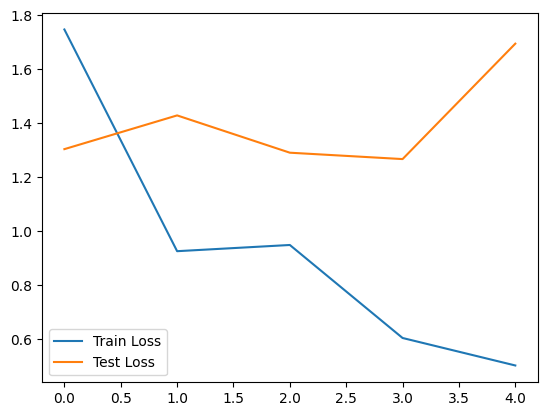

In [94]:
plt.plot(train_losses,label='Train Loss')
plt.plot(test_losses,label='Test Loss')
plt.legend()

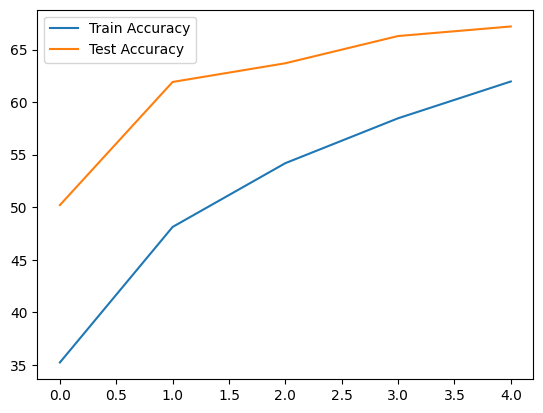

In [95]:
train_acc = [t.cpu().numpy()/600 for t in train_correct]
test_acc = [t.cpu().numpy()/100 for t in test_correct]
plt.plot(train_acc,label='Train Accuracy')
plt.plot(test_acc,label='Test Accuracy')
plt.legend()

# Model Performance on Unseen Data

In [96]:
# New Unseen Data
test_load_all = DataLoader(test_data,batch_size = 10000,shuffle=False)

In [97]:
with torch.no_grad():
  correct = 0
  for X_test,y_test in test_load_all:
    X_test = X_test.to('cuda')
    y_test = y_test.to('cuda')
    y_val= model(X_test)
    predicted = torch.max(y_val.data,1)[1]
    correct += (predicted == y_test).sum()

In [98]:
print('Accuracy is : ',100 * correct.item()/10000)

Accuracy is :  67.2


In [99]:
print("",np.arange(0,10))
print(confusion_matrix(y_test.to('cpu').numpy(),predicted.to('cpu').numpy()))

 [0 1 2 3 4 5 6 7 8 9]
[[771  21  43  22  16   6  15   5  56  45]
 [ 18 813   7  15   1   3  11   3  26 103]
 [ 74  10 507  95  80  80  95  25  15  19]
 [ 33  15  56 507  44 170 101  22  15  37]
 [ 52   7  75 117 537  40  90  55  12  15]
 [ 21   4  47 208  42 556  62  44   3  13]
 [  9   4  32  74  11  19 830   3   4  14]
 [ 25   5  27  60  95  65  17 677   3  26]
 [ 81  62  11  20   2   6  10   8 757  43]
 [ 29 116  10  21   7   7   7  10  28 765]]


# Randomly test model with predictions

		Label : cat 



NameError: name 'torch' is not defined

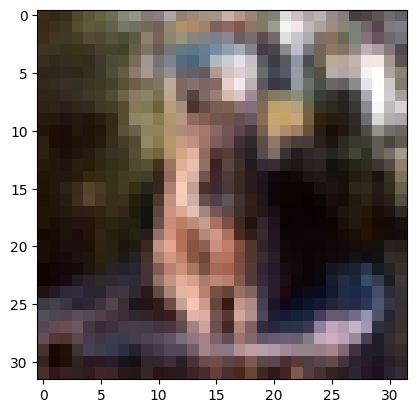

In [100]:
uf.test_model(test_data,class_names,model)

In [ ]:
uf.test_model(test_data,class_names,model)

NameError: name 'uf' is not defined